In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy
from textacy.extract import keyword_in_context

from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()

# Import data set:

In [ ]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

## Keep ALL cases EXCEPT for Unknown Homeland (Ukendt hjemland):

In [ ]:
df_ALL = df_full[df_full.country != "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_ALL[['text']]

df["text"] = df["text"].astype(str)

df.shape

#df.head()


(9132, 1)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [ ]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,9132.0,4178.451051,2169.105671,407.0,2677.0,3814.5,5208.25,22106.0


## Boxplot:

<AxesSubplot:>

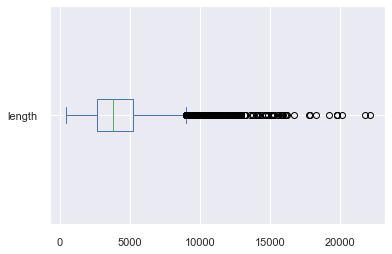

In [ ]:
# Box plot:
df['length'].plot(kind='box', vert=False)

## Histogram:

<AxesSubplot:ylabel='Frequency'>

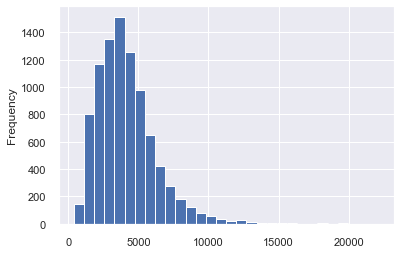

In [ ]:
# Histogram:
df['length'].plot(kind='hist', bins=30)


# Create a pipeline:

Below are the steps taken to process the texts.

In [ ]:
stopwords_lower = list(map(lambda x: x.lower(), stopwords.words('danish')))

STOPWORDS_DANISH = set(stopwords_lower)

nlp = spacy.load("da_core_news_sm")

PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


def remove_stopwords(tokens):
    """custom function to remove stopwords"""
    return [t for t in tokens if t.lower() not in STOPWORDS_DANISH]


def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


def drop_single_letter_words(text):
    return [w for w in text if len(w) > 1]


def lemmatize(text):
    """custom function to lemmatize text"""
    doc = nlp(' '.join(text))
    # pos_tagged_text = text.pos
    return [token.lemma_ for token in doc]


# def remove_junk(text):
#     # Creating a spacy object
#     doc = nlp(' '.join(text))
#     # Checking if POS tag is X and printing them
#     for token in doc:
#         if token.pos_ == 'X':
#             print(token.text)
#     # Removing the tokens whose POS tag is junk.
#     clean_doc = [token.text for token in doc if not token.pos_ == 'X']

#     return clean_doc


Steps can be added or removed from the pipeline.

In [ ]:
pipeline = [str.lower, remove_punctuation, tokenize,
            drop_single_letter_words, remove_stopwords, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [ ]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [ ]:
df.head()

,text,length,tokens,num_tokens
0,Nævnet stadfæstede i marts 2022 Udlænd...,3046,"[nævn, stadfæste, marts, udlændingestyrelse, a...",240
1,Nævnet stadfæstede i marts 2022 Udlænd...,2437,"[nævn, stadfæste, marts, udlændingestyrelse, a...",189
2,Nævnet stadfæstede i marts 2022 Udlænd...,2754,"[nævn, stadfæste, marts, udlændingestyrelse, a...",221
3,Nævnet stadfæstede i marts 2022 Udlænd...,2934,"[nævn, stadfæste, marts, udlændingestyrelse, a...",237
4,Nævnet stadfæstede i marts 2022 Udlænd...,5252,"[nævn, stadfæste, marts, udlændingestyrelse, a...",404
